# Finding the Rotation Curve of an Asteroid or Comet with TESScut and lightkurve
---

## Learning Goals

By the end of this tutorial, you will:
- Understand what a TESS cutout of a moving target is.
- Use the `Tesscut` feature of `astroquery` to find a cutout of an asteroid or comet by name.
- Plot the lightcurve using lightkurve
- Find the rotation period of a bright asteroid using lightkurve

## Introduction

NASA's [Transiting Exoplanet Survey Satellite, or TESS](https://archive.stsci.edu/missions-and-data/tess), was designed to detect planets orbiting bright stars. There are a number of different kinds of [TESS data products](https://heasarc.gsfc.nasa.gov/docs/tess/data-products.html) available in the MAST archive, including:
- FFI (full-frame image) time series contain the entire image captured by the camera taken at different times; these are large views of the sky.
- Target Pixel Files (TPFs) are smaller subsets of full images focused on a single target. They are "postage-stamp" sized images separated by smaller time intervals than FFIs.
- Light Curve Files are derived from the TPFs using Simple Aperture Photometry (SAP). 

Though TESS was designed to study stars and the signatures of exoplanets orbiting them, other objects inevitably are observed within the FFIs. In particular, some asteroids and comets move through the observing sectors. [Pál et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJS..247...26P/abstract) noted:

>"While its primary mission avoids the vicinity of the ecliptic plane by approximately six degrees, the scale height of the solar system debris disk is large enough to place various small body populations in the field of view." 
    
Because small bodies like asteroids and comets are moving targets, they don't have fixed RA and Dec coordinates. The MAST archive's [TESScut](https://mast.stsci.edu/tesscut/) tool has built-in features to find all of the sectors that include observations of a moving target, so long as the object's name or ID can be understood by the [JPL Horizon ephemerades interface](https://ssd.jpl.nasa.gov/horizons/app.html#/). `TESScut` can then return a "cutout" of the full-frame images centered on the target as it moves through the observing sector. With this cutout, we can perform some simple aperture photometry on the target with `lightkurve`. 

In [Pál et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJS..247...26P/abstract), the bright asteroid 354 Eleonora (often just called "Eleonora") was found to have a rotation period of 4.27735 hours and had a mean magnitude of about 9.4 while observed by TESS. 

In this tutorial, we will use `TESScut` to download a cutout of the TESS observations of Eleonora and use `lightkurve` to create a light curve of Eleonora and find its rotation period. This simple method will work because Eleonora is so bright. Generally, for fainter solar system objects, more involved photometry methods will be needed. We'll investigate why in one of the exercises. 

The workflow for this notebook consists of:
- Searching the TESS archive by moving target name using astroquery
- Investigating the results of TESScut
- Plotting the cutout in lightkurve
- Finding the rotation period from the light curve's periodogram
- Exercises

## Imports

- *numpy* to handle array functions
- *astropy.io fits* for acccessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *matplotlib.pyplot* for plotting data

JRK be sure to review when done-ish.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from astropy.io import fits
from astropy.table import Table
#from astroquery.mast import Mast
#from astroquery.mast import Observations
import astropy.units as u

# JRK be sure to review when done-ish.

#import requests # Not doing this. 
from astroquery.mast import Tesscut
import lightkurve as lk
from astropy.visualization import time_support

## Searching the TESS archive by moving target name using astroquery

You can use the [TESScut webpage](https://mast.stsci.edu/tesscut/) to make a cutout of a TESS FFI time series; for a solar system object like an asteroid or comet, be sure to click on the "Moving Target" button at the top after the words "Create cutout based on." 

To create a scriptable process for using TESScut, we can instead use the Built-in [MAST functionality in astroquery to access TESScut](https://astroquery.readthedocs.io/en/latest/mast/mast.html#cutouts). Let's set our object name to "Eleonora."

In [2]:
objname='Eleonora'

TESS observed distinct areas of the sky called Sectors. We can use `Tesscut.get_sectors` to see which (if any) sectors inlude observations of our object. Whenever using Tesscut with a moving target, we must always set `moving_target=True` (the default is `False`). 

In [3]:
sector_table=Tesscut.get_sectors(objectname=objname, moving_target=True)
print(sector_table)

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0006-1-1      6      1   1
tess-s0023-1-1     23      1   1


Next we'll use `Tess.get_cutouts` to, as the name implies, get the cutouts. Again, we must include the keyword `moving_target=True`.

We will also add the `size` keyword to choose how many pixels (in both width and height) we want our cutout to be. For this tutorial, we will choose a 10x10 cutout. This choice significantly affects the size of the .fits files and the time it will take to complete `get_cutouts`. 

You can specify e.g. `sector=6` when requesting a single cutout, but it's not necessary. Without specifying the sector, we will receive results for all sectors available. 

In [4]:
hdulist = Tesscut.get_cutouts(objectname=objname, moving_target=True, size=10)
print('Length of hdulist =',len(hdulist))

Length of hdulist = 2


## Investigating the results of TESScut
The result of Tesscut.get_cutouts is a list of .fits datasets; there is one element in the list per sector returned above. The contents of each element in `hdulist` are identical to the .fits files downloaded from the [TESSCut](https://mast.stsci.edu/tesscut/) website with the same selections (target name and size). Let's examine the *second* item in the list, because it will be the more interesting of the two, as we'll see soon.

In [5]:
hdulist[1].info()

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  PIXELS        1 BinTableHDU    150   444R x 16C   [D, E, J, 100J, 100E, 100E, 100E, 100E, J, E, E, 38A, D, D, D, D]   
  2  APERTURE      1 ImageHDU        97   (2136, 2078)   int32   


The result that we get is described in the [astrocut documentation on Path Focused Target Pixel Files](https://astrocut.readthedocs.io/en/latest/astrocut/file_formats.html#path-focused-target-pixel-files). Extension 0 is the header with metadata. Astronomers not used to working with moving targets may note that the `RA_OBJ` and `DEC_OBJ` keywords are not there!

Extension 1 is the data we most want in the form of a binary table; we'll look at that next.

But first, Extension 2, if present, is an image the size of the full-frame image (FFI) that the cutouts were drawn from. It's an array of 1's if the pixel was used and 0 if the pixel was not. By displaying this array as an image, we can see the trajectory of our moving target through the TESS sector. 

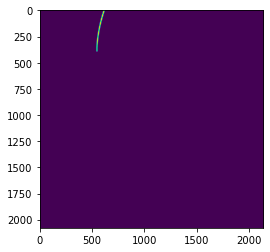

In [6]:
plt.imshow(hdulist[1][2].data)

It looks like, for this sector, Eleonora is partially outside of the sector during the course of the observations.

Going back to Extension 1, this is a binary table with 358 rows and 16 columns. The header keys `TTYPE1`, `TTYPE2`, etc. tell us the names of each column. Let's view each of them. Additionally, some of the (row, column) entries in this extension will actually be arrays of exactly the cutout size we requested. To show this, we'll also print the shape of the entries of the first row along with the column name.

In [7]:
for i in range(1,16): print(i-1,
                            hdulist[1][1].header['TTYPE'+str(i)],
                            np.shape(hdulist[1][1].data[0][i]))

0 TIME ()
1 TIMECORR ()
2 CADENCENO (10, 10)
3 RAW_CNTS (10, 10)
4 FLUX (10, 10)
5 FLUX_ERR (10, 10)
6 FLUX_BKG (10, 10)
7 FLUX_BKG_ERR ()
8 QUALITY ()
9 POS_CORR1 ()
10 POS_CORR2 ()
11 FFI_FILE ()
12 TGT_X ()
13 TGT_Y ()
14 TGT_RA ()


The column of index i=4 is actually an array of fluxes. We can check the header info to confirm the units of the flux and of the time, and then we can view the first cutout, along with the coordinates (RA, Dec) of Eleonora at the time the cutout was taken.

In [8]:
hdulist[1][1].header['TUNIT5']

'e-/s'

In [9]:
hdulist[1][1].header['TUNIT1']

'BJD - 2457000, days'

RA:  213.3993203187711
Dec:  14.185531754865366


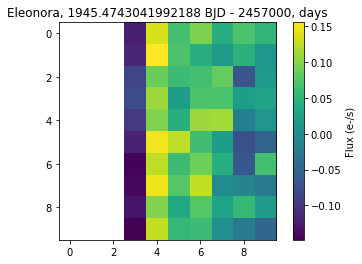

In [10]:
fig,ax=plt.subplots(1,1)
imgplot=plt.imshow(hdulist[1][1].data[0][4])
plt.colorbar(label='Flux (e-/s)')
ax.set_title(objname+', '+str(hdulist[1][1].data[0][0])+' '+str(hdulist[1][1].header['TUNIT1']))
print('RA: ',hdulist[1][1].data[0][14])
print('Dec: ',hdulist[1][1].data[0][15])

Something looks wrong! Let's view a later image instead, say at row (or "cadence") 100.

RA:  213.07099059474592
Dec:  14.509726204925824


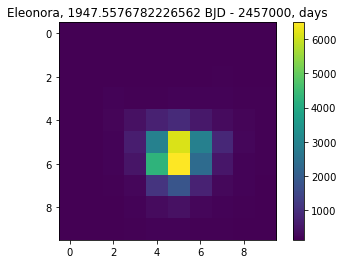

In [11]:
i=100
fig,ax=plt.subplots(1,1)
imgplot=plt.imshow(hdulist[1][1].data[i][4])
plt.colorbar()
ax.set_title(objname+', '+str(hdulist[1][1].data[i][0])+' '+str(hdulist[1][1].header['TUNIT1']))
print('RA: ',hdulist[1][1].data[i][14])
print('Dec: ',hdulist[1][1].data[i][15])

The target is clearly there. Remember, we thought the asteroid would not be in the field of view the whole time; this helps us know that the target started out of the frame and moved in. At this later time, a few days later, the target has moved to a different RA and Dec.

## Plotting the cutout in lightkurve

Though `lightkurve` has a `search_tesscut` function, at the time of this tutorial is does not work for moving targets. 

We'll need to save these .fits files locally to load them as Target Pixel Files into `lightkurve`. In a later exercise, you'll confirm that the files we write are the same as those you could download from the [TESSCut](https://mast.stsci.edu/tesscut/) tool in a web browser. 

In [12]:
nsectors=len(hdulist)
for i in range(nsectors): 
    hdulist[i].writeto(objname+'_'+str(i)+'.fits',overwrite=True)

Now, we'll load each .fits file in as a `TessTargetPixelFile` object and collect all the sectors together into a `TargetPixelFileCollection` object; basically, a list of target pixel file (TPF) objects.

In [13]:
for i in range(nsectors):
    tpf = lk.TessTargetPixelFile(objname+'_'+str(i)+'.fits')
    if i==0: 
        tpfc=lk.TargetPixelFileCollection([tpf])
    else:
        tpfc.append(tpf)

For one TPF at a time, we can use the `interact` feature of `lightkurve` to easily view a light curve (on the left) as a function of time. On the right, we'll see the image of 10x10 image of Eleonora, overlaid with the aperture mask used for the aperture photometry that produced the light curve. Let's view the second sector observed by TESS. Try clicking and dragging the "Cadence Number" bar to see how Eleonora moves through the field of view. Can you tell that it is rotating every few hours ?

In [14]:
tpfc[1].interact()

The lightcurve above confirms our suspicion that Eleonora was not viewable in the sector during the whole time of observation because it moved *into* the FFI during the observation. At the time of the writing of this tutorial, these cadences do not have a quality flag associated with them. 

We can check that all of the cadences loaded in this observation have a quality flag of zero:

In [15]:
np.sum(tpfc[0].quality)

0

To handle this issue, we will make the lightcurve for each TPF, collect them as a list in a `LightCurveCollection` object and then truncate the lightcurves to remove the blank cadences.

In [16]:
for i in range(nsectors):
    lc=tpfc[i].to_lightcurve()
    if i==0: 
        lcc=lk.LightCurveCollection([lc])
    else:
        lcc.append(lc)    

Based on the `interact` screen above, the second lightkurve should be truncated for all rows before cadence number 59. In an exercise below, you can confirm for yourself that we should truncate the first lightkurve after cadence number 293. 



In [17]:
lcc[0]=lcc[0].truncate(after=293,column='cadenceno')
lcc[1]=lcc[1].truncate(before=59,column='cadenceno')

The second lightcurve also shows two notable features around cadences 191-203 and 366-381. By examining the Pixel data screen on the right, it's clear that Eleonora passed by two stars at those times, and the flux from both stars is added into the aperture photometry and resulting light curve. We should also remove those cadences from our lightcurve or they may interfere with the periodogram. In this case, we can use `remove_outliers` to remove fluxes greater than 2 standard deviations from the median. In a later exercise, you can confirm that this does not modify the rest of the periodic fluctuation of the lightcurve. 

In [18]:
lcc[1]=lcc[1].remove_outliers(sigma_upper=2)

Now we're ready to view the two lightcurves on one plot. 

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

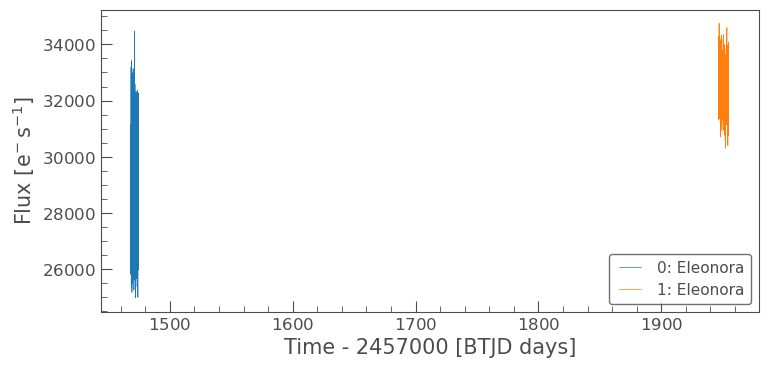

In [19]:
lcc.plot()

Admittedly, that view is not very helpful because of the large gap in time between observations of Eleonora. However, this time gap is important because it explains the difference in mean flux values between the two observations. Eleonora must have either been farther away from us during the first sector (and hence, dimmer) *or* possibly in a dimmer phase due to its position from us relative to the sun.

Still, having all of this data combined helps confirm the periodic nature of the flux variation, and hence, the period of the rotation of the asteroid. So, we will still stitch these together to combine them into one light curve and view the result. In an exercse, you can investigate if this affects the rotation period.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

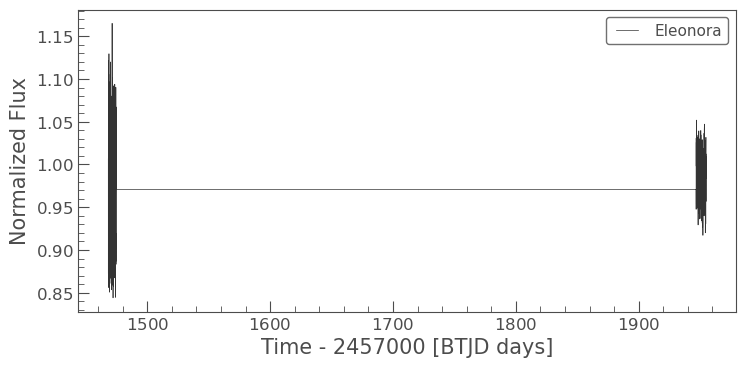

In [20]:
lc_stitched=lcc.stitch()
lc_stitched.plot()

## Finding the rotation period from the light curve's periodogram
Next, we'll create the periodogram of this stitched lightcurve. More information can be found in the lightkurve documentation: [What are Periodogram objects?](https://docs.lightkurve.org/tutorials/1-getting-started/what-are-periodogram-objects.html)

In [21]:
pg=lc_stitched.to_periodogram()

/Users/julia/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<AxesSubplot:xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power'>

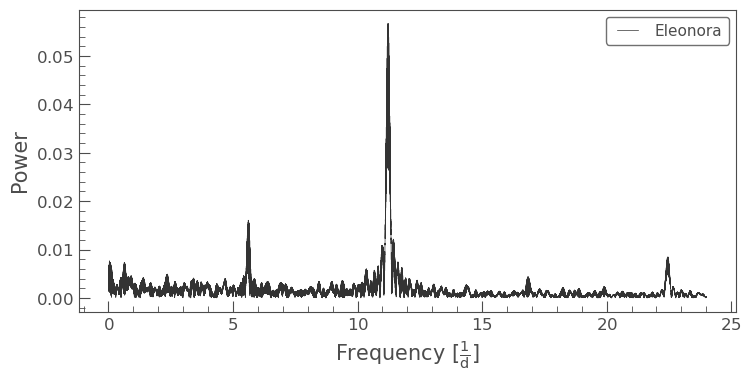

In [22]:
pg.plot()

There is clearly a frequency around 11 1/d found with maximum power. That corresponds to a period of:

In [23]:
pg.period_at_max_power

<Quantity 0.08910418 d>

Or, in hours:

In [24]:
pg.period_at_max_power.to(u.hr)

<Quantity 2.13850039 h>

[Pál et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJS..247...26P/abstract), found a rotation period of 4.27735 hours; their period is almost a perfectly integer multiple of ours (times 2). Their period corresponds to second highest peak in our periodogram. We can view the difference this makes by looking at the folded light curve, first with our period, and next with our period times two:

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

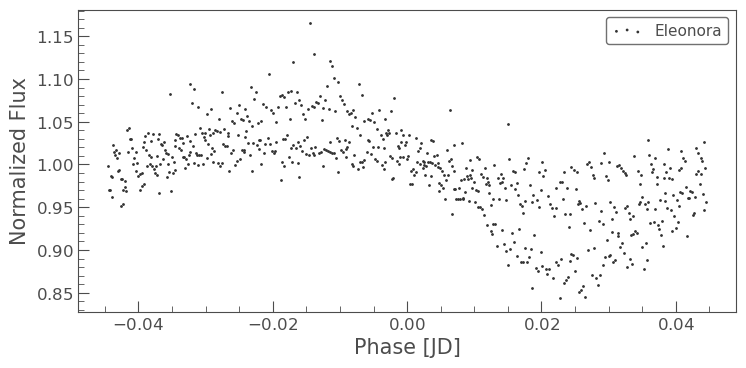

In [25]:
lc_stitched.fold(period=pg.period_at_max_power).scatter()

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

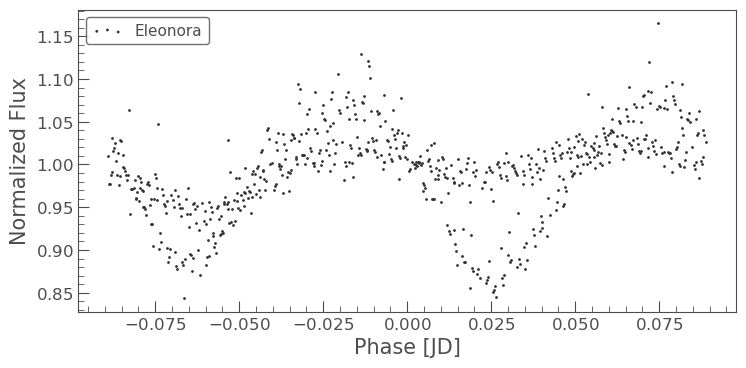

In [26]:
lc_stitched.fold(period=2*pg.period_at_max_power).scatter()

The accepted period (the second one we viewed) produced better folded lightcurve. There appear to be two separate lightcurves: one with higher variation from the normalized flux, and one with lower variation. These correspond, respectively, to the first and second sectors, where the mean brightness of the asteroid was notably different. 

## Exercises

1. Confirm that the first lightcurve in our hdulist should be truncated after cadence number 293. 

In [27]:
# Place for code for Exercise 1

2. Confirm that using a `remove_outlier` cutoff of `sigma_upper=2` did not affect the other cadences of the lightcurve for the second sector. At this point in the tutorial, the second sector's original light curve is still saved under the variable name `lc`; plot a graph of its time vs. flux columns and then overplot our sigma-clipped time and flux columns. Hint: You'll need to [load `time_support()` first](https://docs.astropy.org/en/stable/visualization/matplotlib_integration.html#plotting-times) in order to use the time column in matplotlib. 

In [28]:
# Place for code for Exercise 2

3. Determine if the rotation period returned by `lightkurve` is different when using only one sector's light curve at a time. 

In [29]:
# Place for code for Exercise 3

4. Use the interactive [TESSCut webpage](https://mast.stsci.edu/tesscut/) to download 10x10 cutouts for all sectors observing Eleonora. Be sure to select "Moving Target" at the top! Load the resulting fits files in and confirm that they are identical to the items in `hdulist` above. Hint: Astropy has a built-in method called [FITSDiff](https://docs.astropy.org/en/stable/io/fits/api/diff.html). 

In [30]:
# Place for code for Exercise 4

5. Try recreating the procedure above to find the rotation period for a fainter (higher magnitude) small body from [Pál et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJS..247...26P/abstract) such as Hippodamia. What issues do you encounter in this case?

In [31]:
# Place for code for Exercise 5

6. Use [astroquery's Minor Planet Center Queries (MPC)](https://astroquery.readthedocs.io/en/latest/mpc/mpc.html?highlight=mpc#ephemerides) `get_ephemeris` feature to investigate why the median flux for the first sector's observations is lower than for the second sector's observations. The times of each cadence are in the light curve's `time` column.

In [32]:
# Place for code for Exercise 6

## Citations

If you use `astropy`, `lightkurve`, or `TESScut` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](http://docs.lightkurve.org/about/citing.html)
* Cite [Brasseur et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ascl.soft05007B/abstract) for TESScut

## About this Notebook

**Author:** Julia Kamenetzky, ScienceBetter Consultant <br>
**Keywords:** <br>
**Last Updated:**  Sep 2022<br>
**Next Review:** Feb 2023<br>
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 